# Purpose

This notebook will guide you through the basic steps to get started with Active Vision.

By the end of this notebook, you will be able to:

- Understand the basic workflow of active learning
- Understand the basic components of Active Vision
- Understand how to use Active Vision to train a model and iteratively improve your dataset

## Learner

With the initial dataset ready, we can load it into an `ActiveLearner` object with a name for the cycle.

In [1]:
from active_vision import ActiveLearner

al = ActiveLearner(name="cycle-1")

## Load Model
Now let's load a model to be used for active learning. Any `fastai` and `timm` models are supported.

I'd recommend using a model with a small number of parameters, such as `resnet18` to make sure the active learning cycle is fast. 
This model will only be used in the active learning cycle to sample the most impactful samples to label.

In [2]:
al.load_model(model="resnet18", pretrained=True)

2025-02-04 21:53:06.162 | INFO     | active_vision.core:_detect_optimal_device:87 - Apple Silicon GPU detected - will load model on MPS
2025-02-04 21:53:06.162 | INFO     | active_vision.core:load_model:70 - Loading a pretrained timm model `resnet18` on `mps`


## Load Initial Dataset

First, let's load the initial dataset we prepared earlier.

In [3]:
import pandas as pd

initial_samples = pd.read_parquet("initial_samples.parquet")
initial_samples

filepath             label
0   data/imagenette/train/n02102040/n02102040_2788...  English springer
1   data/imagenette/train/n02102040/n02102040_3759...  English springer
2   data/imagenette/train/n02102040/n02102040_1916...  English springer
3   data/imagenette/train/n02102040/n02102040_6147...  English springer
4   data/imagenette/train/n02102040/n02102040_403....  English springer
..                                                ...               ...
95  data/imagenette/train/n01440764/n01440764_1004...             tench
96  data/imagenette/train/n01440764/n01440764_3153...             tench
97  data/imagenette/train/n01440764/n01440764_1284...             tench
98  data/imagenette/train/n01440764/n01440764_3997...             tench
99  data/imagenette/train/n01440764/n01440764_2978...             tench

[100 rows x 2 columns]

We can load the initial samples into the `ActiveLearner` object. Point the `filepath_col` and `label_col` to the columns in the dataframe.

In [4]:
al.load_dataset(initial_samples, filepath_col="filepath", label_col="label")

2025-02-04 21:53:06.221 | INFO     | active_vision.core:load_dataset:119 - Loading dataset from `filepath` and `label` columns
2025-02-04 21:53:06.257 | INFO     | active_vision.core:load_dataset:153 - Creating new learner
2025-02-04 21:53:08.147 | INFO     | active_vision.core:_optimize_learner:97 - Enabled mixed precision training
2025-02-04 21:53:08.148 | INFO     | active_vision.core:_finalize_setup:105 - Done. Ready to train.


Let's inspect one batch of the loaded dataset.

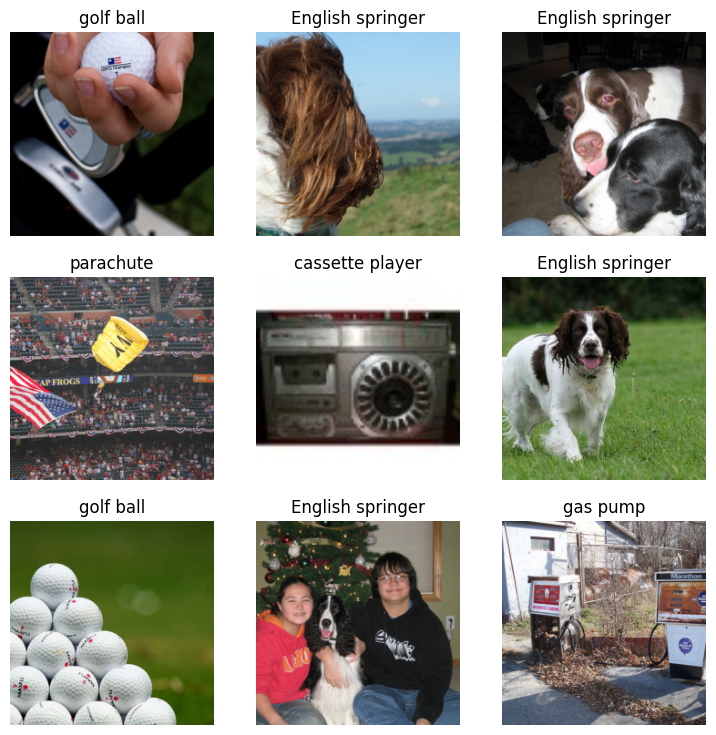

In [5]:
al.show_batch()

You can inspect the train and validation sets too.

In [6]:
al.train_set

filepath             label
74  data/imagenette/train/n03445777/n03445777_1058...         golf ball
53  data/imagenette/train/n03417042/n03417042_9128...     garbage truck
29  data/imagenette/train/n02979186/n02979186_7354...   cassette player
96  data/imagenette/train/n01440764/n01440764_3153...             tench
70  data/imagenette/train/n03445777/n03445777_4354...         golf ball
..                                                ...               ...
89  data/imagenette/train/n03888257/n03888257_4345...         parachute
2   data/imagenette/train/n02102040/n02102040_1916...  English springer
35  data/imagenette/train/n03000684/n03000684_1381...         chain saw
97  data/imagenette/train/n01440764/n01440764_1284...             tench
32  data/imagenette/train/n03000684/n03000684_8985...         chain saw

[80 rows x 2 columns]

In [7]:
al.valid_set

filepath          label
75  data/imagenette/train/n03445777/ILSVRC2012_val...      golf ball
15  data/imagenette/train/n03394916/n03394916_3860...    French horn
98  data/imagenette/train/n01440764/n01440764_3997...          tench
90  data/imagenette/train/n01440764/n01440764_8805...          tench
31  data/imagenette/train/n03000684/n03000684_7905...      chain saw
65  data/imagenette/train/n03425413/n03425413_2074...       gas pump
59  data/imagenette/train/n03417042/n03417042_79.JPEG  garbage truck
44  data/imagenette/train/n03028079/n03028079_8632...         church
30  data/imagenette/train/n03000684/n03000684_9935...      chain saw
18  data/imagenette/train/n03394916/n03394916_3080...    French horn
58  data/imagenette/train/n03417042/ILSVRC2012_val...  garbage truck
11  data/imagenette/train/n03394916/n03394916_2128...    French horn
19  data/imagenette/train/n03394916/n03394916_3543...    French horn
79  data/imagenette/train/n03445777/n03445777_1250...      golf ball
12  data/imagenette/train/n03394916/n03394916_5342...    French horn
16  data/imagenette/train/n03394916/n03394916_4308...    French horn
64  data/imagenette/train/n03425413/n03425413_1007...       gas pump
77  data/imagenette/train/n03445777/n03445777_9105...      golf ball
92  data/imagenette/train/n01440764/n01440764_1520...          tench
39  data/imagenette/train/n03000684/n03000684_2753...      chain saw

## Train 

Now that we have the initial dataset, we can train the model.

But first, let's check the optimal learning rate for the model.

2025-02-04 21:53:08.541 | INFO     | active_vision.core:lr_find:194 - Finding optimal learning rate
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


2025-02-04 21:53:16.820 | INFO     | active_vision.core:lr_find:196 - Optimal learning rate: 0.0030199517495930195


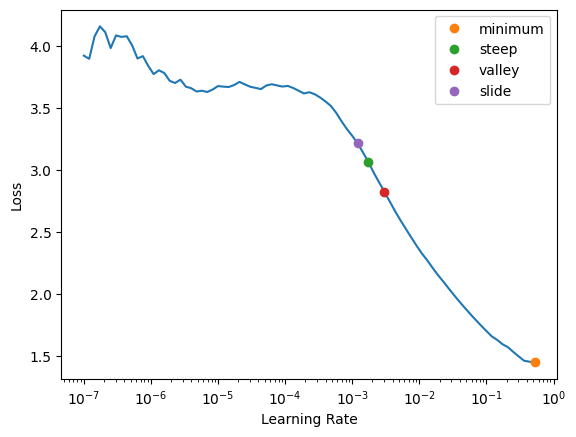

In [8]:
al.lr_find()

Not let's use the optimal learning rate to train the model end-to-end for 10 epochs and 3 epochs of head tuning. In the head tuning phase, the model will be frozen and only the head will be trained.

2025-02-04 21:53:16.982 | INFO     | active_vision.core:train:207 - Training head for 3 epochs
2025-02-04 21:53:16.983 | INFO     | active_vision.core:train:208 - Training model end-to-end for 10 epochs
2025-02-04 21:53:16.983 | INFO     | active_vision.core:train:209 - Learning rate: 0.005 with one-cycle learning rate scheduler


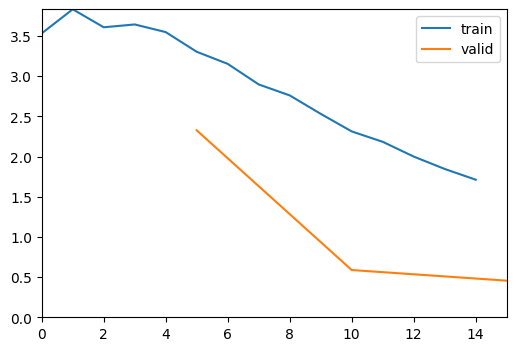

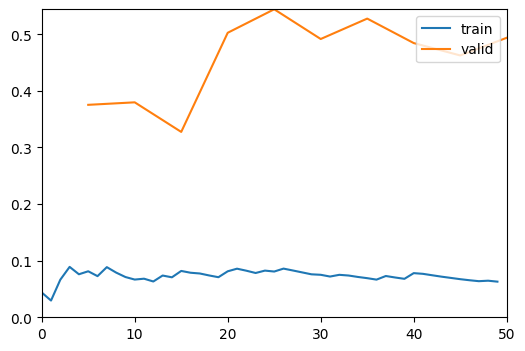

In [9]:
al.train(epochs=10, lr=5e-3, head_tuning_epochs=3)

## Evaluate

Now that we have a trained model, we can evaluate it on the evaluation set.

In [10]:
evaluation_df = pd.read_parquet("evaluation_samples.parquet")
evaluation_df

filepath            label
0     data/imagenette/val/n03394916/n03394916_32422....      French horn
1     data/imagenette/val/n03394916/n03394916_69132....      French horn
2     data/imagenette/val/n03394916/n03394916_33771....      French horn
3     data/imagenette/val/n03394916/n03394916_29940....      French horn
4     data/imagenette/val/n03394916/ILSVRC2012_val_0...      French horn
...                                                 ...              ...
3920  data/imagenette/val/n02979186/n02979186_27392....  cassette player
3921  data/imagenette/val/n02979186/n02979186_2742.JPEG  cassette player
3922  data/imagenette/val/n02979186/n02979186_2312.JPEG  cassette player
3923  data/imagenette/val/n02979186/n02979186_12822....  cassette player
3924  data/imagenette/val/n02979186/ILSVRC2012_val_0...  cassette player

[3925 rows x 2 columns]

In [11]:
al.evaluate(evaluation_df, filepath_col="filepath", label_col="label")

/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


2025-02-04 21:53:40.605 | INFO     | active_vision.core:evaluate:285 - Accuracy: 90.24%


0.902420382165605

That is a good start. ~90% accuracy is not bad for a first try with only 100 labeled samples. Let's see if we can improve it.

Let's save the summary of the cycle.

In [12]:
al.summary()

2025-02-04 21:53:50.757 | INFO     | active_vision.core:summary:578 - Saved results to cycle-1_20250204_215350_acc_90.24%_n_100.parquet


name  accuracy  train_set_size  valid_set_size  dataset_size  \
0  cycle-1   0.90242              80              20           100   

   num_classes     model  pretrained                              loss_fn  \
0           10  resnet18        True  FlattenedLoss of CrossEntropyLoss()   

  device  seed  batch_size  image_size  
0    mps  None          16         224

The above will create a `.parquet` file with the summary of the cycle. This will be useful for tracking the progress of the active learning process.

## Predict

Using the model, we can predict the labels of the unlabeled samples and get the most impactful samples to label.


In [13]:
df = pd.read_parquet("unlabeled_samples.parquet")
filepaths = df["filepath"].tolist()
len(filepaths)

9369

In [14]:
pred_df = al.predict(filepaths, batch_size=128)
pred_df

2025-02-04 21:54:00.351 | INFO     | active_vision.core:predict:216 - Running inference on 9369 samples
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


filepath       pred_label  \
0     data/imagenette/train/n03394916/n03394916_4437...      French horn   
1     data/imagenette/train/n03394916/n03394916_4241...      French horn   
2     data/imagenette/train/n03394916/n03394916_3880...      French horn   
3     data/imagenette/train/n03394916/n03394916_2412...      French horn   
4     data/imagenette/train/n03394916/n03394916_1128...      French horn   
...                                                 ...              ...   
9364  data/imagenette/train/n02979186/n02979186_8089...  cassette player   
9365  data/imagenette/train/n02979186/n02979186_1944...  cassette player   
9366  data/imagenette/train/n02979186/n02979186_1107...  cassette player   
9367  data/imagenette/train/n02979186/n02979186_2938...  cassette player   
9368  data/imagenette/train/n02979186/n02979186_93.JPEG  cassette player   

      pred_conf                                              probs  \
0        0.8815  [0.0, 0.8815, 0.1002, 0.0007, 0.0056, 0.0015, ...   
1        0.9981  [0.0, 0.9981, 0.0002, 0.0, 0.0001, 0.0003, 0.0...   
2        0.9605  [0.0014, 0.9605, 0.0004, 0.0042, 0.0068, 0.017...   
3        0.9916  [0.0, 0.9916, 0.0058, 0.0001, 0.0003, 0.0019, ...   
4        0.9345  [0.0006, 0.9345, 0.0001, 0.0499, 0.0002, 0.009...   
...         ...                                                ...   
9364     0.9998  [0.0, 0.0, 0.9998, 0.0001, 0.0, 0.0, 0.0, 0.0,...   
9365     0.9978  [0.0003, 0.0002, 0.9978, 0.0014, 0.0, 0.0003, ...   
9366     0.9976  [0.0001, 0.0, 0.9976, 0.002, 0.0002, 0.0, 0.0,...   
9367     0.9756  [0.0, 0.0026, 0.9756, 0.0212, 0.0005, 0.0, 0.0...   
9368     0.9247  [0.0, 0.0, 0.9247, 0.0745, 0.0001, 0.0, 0.0, 0...   

                                                 logits  \
0     [-4.0315, 6.3779, 4.2033, -0.7827, 1.3138, 0.0...   
1     [-4.304, 8.3362, -0.0308, -1.64, -0.8373, 0.17...   
2     [-1.2137, 5.3527, -2.4653, -0.0855, 0.398, 1.3...   
3     [-2.7646, 8.6685, 3.5195, -0.3958, 0.423, 2.42...   
4     [-0.7557, 6.6546, -2.7884, 3.7239, -1.8325, 2....   
...                                                 ...   
9364  [0.2201, -0.8615, 11.2814, 2.2068, -2.6583, -2...   
9365  [1.1453, 0.7587, 9.4202, 2.8624, -1.6734, 1.22...   
9366  [-0.2329, -1.2031, 9.2606, 3.0241, 0.9305, -3....   
9367  [-2.3168, 1.9011, 7.8416, 4.0137, 0.2384, -3.5...   
9368  [-3.7599, -2.0933, 7.9608, 5.4418, -0.9875, -3...   

                                             embeddings  
0     [1.5122, 2.9872, -0.0116, -2.0296, -1.1489, -3...  
1     [1.8019, -2.0897, -0.1908, -1.2324, 3.1603, -2...  
2     [-1.7658, -1.084, 0.1105, 0.6327, -0.3034, -0....  
3     [0.5607, -0.0849, -0.0111, -2.5747, 1.7406, -3...  
4     [0.0593, -2.8017, -0.8326, 0.0533, 0.3513, -4....  
...                                                 ...  
9364  [2.7389, -0.1937, 3.834, 3.7718, -1.3812, 3.20...  
9365  [0.8961, 0.8141, 3.2657, -1.6927, -0.944, 1.28...  
9366  [-0.9728, -0.7958, 2.6238, 0.8788, 0.139, 3.13...  
9367  [-0.4059, -0.2213, 1.5756, 3.1359, 0.0702, 1.0...  
9368  [-1.5722, 0.8393, 0.0824, 0.3304, -1.0368, 1.8...  

[9369 rows x 6 columns]

## Sample

With the predicted labels, we can sample the most impactful samples to label using active learning strategies.

For this example, we will use the `sample_combination` strategy to sample 50 samples from each strategy listed below in the specified proportions.

In [15]:
samples = al.sample_combination(
    pred_df,
    num_samples=50,
    combination={
        "least-confidence": 0.4,
        "ratio-of-confidence": 0.2,
        "entropy": 0.2,
        "model-based-outlier": 0.1,
        "random": 0.1,
    },
)

samples

2025-02-04 21:54:36.646 | INFO     | active_vision.core:sample_combination:498 - Using combination sampling to get 50 samples
2025-02-04 21:54:36.648 | INFO     | active_vision.core:sample_uncertain:305 - Using least confidence strategy to get top 20 samples
2025-02-04 21:54:36.654 | INFO     | active_vision.core:sample_uncertain:328 - Using ratio of confidence strategy to get top 10 samples
2025-02-04 21:54:36.676 | INFO     | active_vision.core:sample_uncertain:342 - Using entropy strategy to get top 10 samples
/Users/dnth/Desktop/active-vision/src/active_vision/core.py:345: RuntimeWarning: divide by zero encountered in log2
  df.loc[:, "score"] = df["probs"].apply(lambda x: -np.sum(x * np.log2(x)))
/Users/dnth/Desktop/active-vision/src/active_vision/core.py:345: RuntimeWarning: invalid value encountered in multiply
  df.loc[:, "score"] = df["probs"].apply(lambda x: -np.sum(x * np.log2(x)))
2025-02-04 21:54:36.708 | INFO     | active_vision.core:sample_diverse:388 - Using model-based

2025-02-04 21:54:36.977 | INFO     | active_vision.core:sample_random:460 - Sampling 5 random samples


filepath             strategy  \
0   data/imagenette/train/n02979186/n02979186_1154...     least-confidence   
1   data/imagenette/train/n01440764/n01440764_1172...     least-confidence   
2   data/imagenette/train/n03888257/n03888257_2944...     least-confidence   
3   data/imagenette/train/n01440764/n01440764_1373...     least-confidence   
4   data/imagenette/train/n03425413/n03425413_1511...     least-confidence   
5   data/imagenette/train/n03445777/n03445777_258....     least-confidence   
6   data/imagenette/train/n03000684/n03000684_3318...     least-confidence   
7   data/imagenette/train/n03888257/n03888257_2793...     least-confidence   
8   data/imagenette/train/n03425413/n03425413_1914...     least-confidence   
9   data/imagenette/train/n03000684/n03000684_3003...     least-confidence   
10  data/imagenette/train/n03000684/n03000684_9113...     least-confidence   
11  data/imagenette/train/n03425413/n03425413_1459...     least-confidence   
12  data/imagenette/train/n03000684/n03000684_2098...     least-confidence   
13  data/imagenette/train/n03425413/n03425413_1438...     least-confidence   
14  data/imagenette/train/n03425413/n03425413_2219...     least-confidence   
15  data/imagenette/train/n03394916/n03394916_2325...     least-confidence   
16  data/imagenette/train/n03417042/n03417042_5698...     least-confidence   
17  data/imagenette/train/n03000684/n03000684_1503...     least-confidence   
18  data/imagenette/train/n03425413/n03425413_3144...     least-confidence   
19  data/imagenette/train/n02102040/n02102040_5983...     least-confidence   
20  data/imagenette/train/n03888257/n03888257_5543...  ratio-of-confidence   
21  data/imagenette/train/n03417042/n03417042_6903...  ratio-of-confidence   
22  data/imagenette/train/n03425413/n03425413_1268...  ratio-of-confidence   
23  data/imagenette/train/n03417042/n03417042_2684...  ratio-of-confidence   
24  data/imagenette/train/n03888257/n03888257_7430...  ratio-of-confidence   
25  data/imagenette/train/n03394916/n03394916_2900...  ratio-of-confidence   
26  data/imagenette/train/n03425413/n03425413_1731...  ratio-of-confidence   
27  data/imagenette/train/n02979186/n02979186_2351...  ratio-of-confidence   
28  data/imagenette/train/n01440764/n01440764_1696...  ratio-of-confidence   
29  data/imagenette/train/n03394916/n03394916_3011...  ratio-of-confidence   
30  data/imagenette/train/n03000684/n03000684_5368...              entropy   
31  data/imagenette/train/n03000684/n03000684_1599...              entropy   
32  data/imagenette/train/n03000684/n03000684_3103...              entropy   
33  data/imagenette/train/n03425413/n03425413_9079...              entropy   
34  data/imagenette/train/n03028079/n03028079_3835...              entropy   
35  data/imagenette/train/n03000684/ILSVRC2012_val...              entropy   
36  data/imagenette/train/n03888257/n03888257_1205...              entropy   
37  data/imagenette/train/n01440764/n01440764_8589...              entropy   
38  data/imagenette/train/n03888257/n03888257_2762...              entropy   
39  data/imagenette/train/n03425413/n03425413_1654...              entropy   
40  data/imagenette/train/n02102040/n02102040_2595...  model-based-outlier   
41  data/imagenette/train/n03445777/n03445777_1386...  model-based-outlier   
42  data/imagenette/train/n02102040/n02102040_539....  model-based-outlier   
43  data/imagenette/train/n03000684/n03000684_1637...  model-based-outlier   
44  data/imagenette/train/n03000684/n03000684_3268...  model-based-outlier   
45  data/imagenette/train/n03000684/n03000684_1471...               random   
46  data/imagenette/train/n02102040/n02102040_3767...               random   
47  data/imagenette/train/n03425413/n03425413_1957...               random   
48  data/imagenette/train/n03028079/n03028079_2035...               random   
49  data/imagenette/train/n03028079/n03028079_2268...               random   

     score        pred_label  pred_conf  \
0   0.7868   cassette p

## Label

Let's label the samples and save them to a parquet file named `combination.parquet`. This should launch a Gradio interface to label the samples.

In [ ]:
al.label(samples, output_filename="combination.parquet")

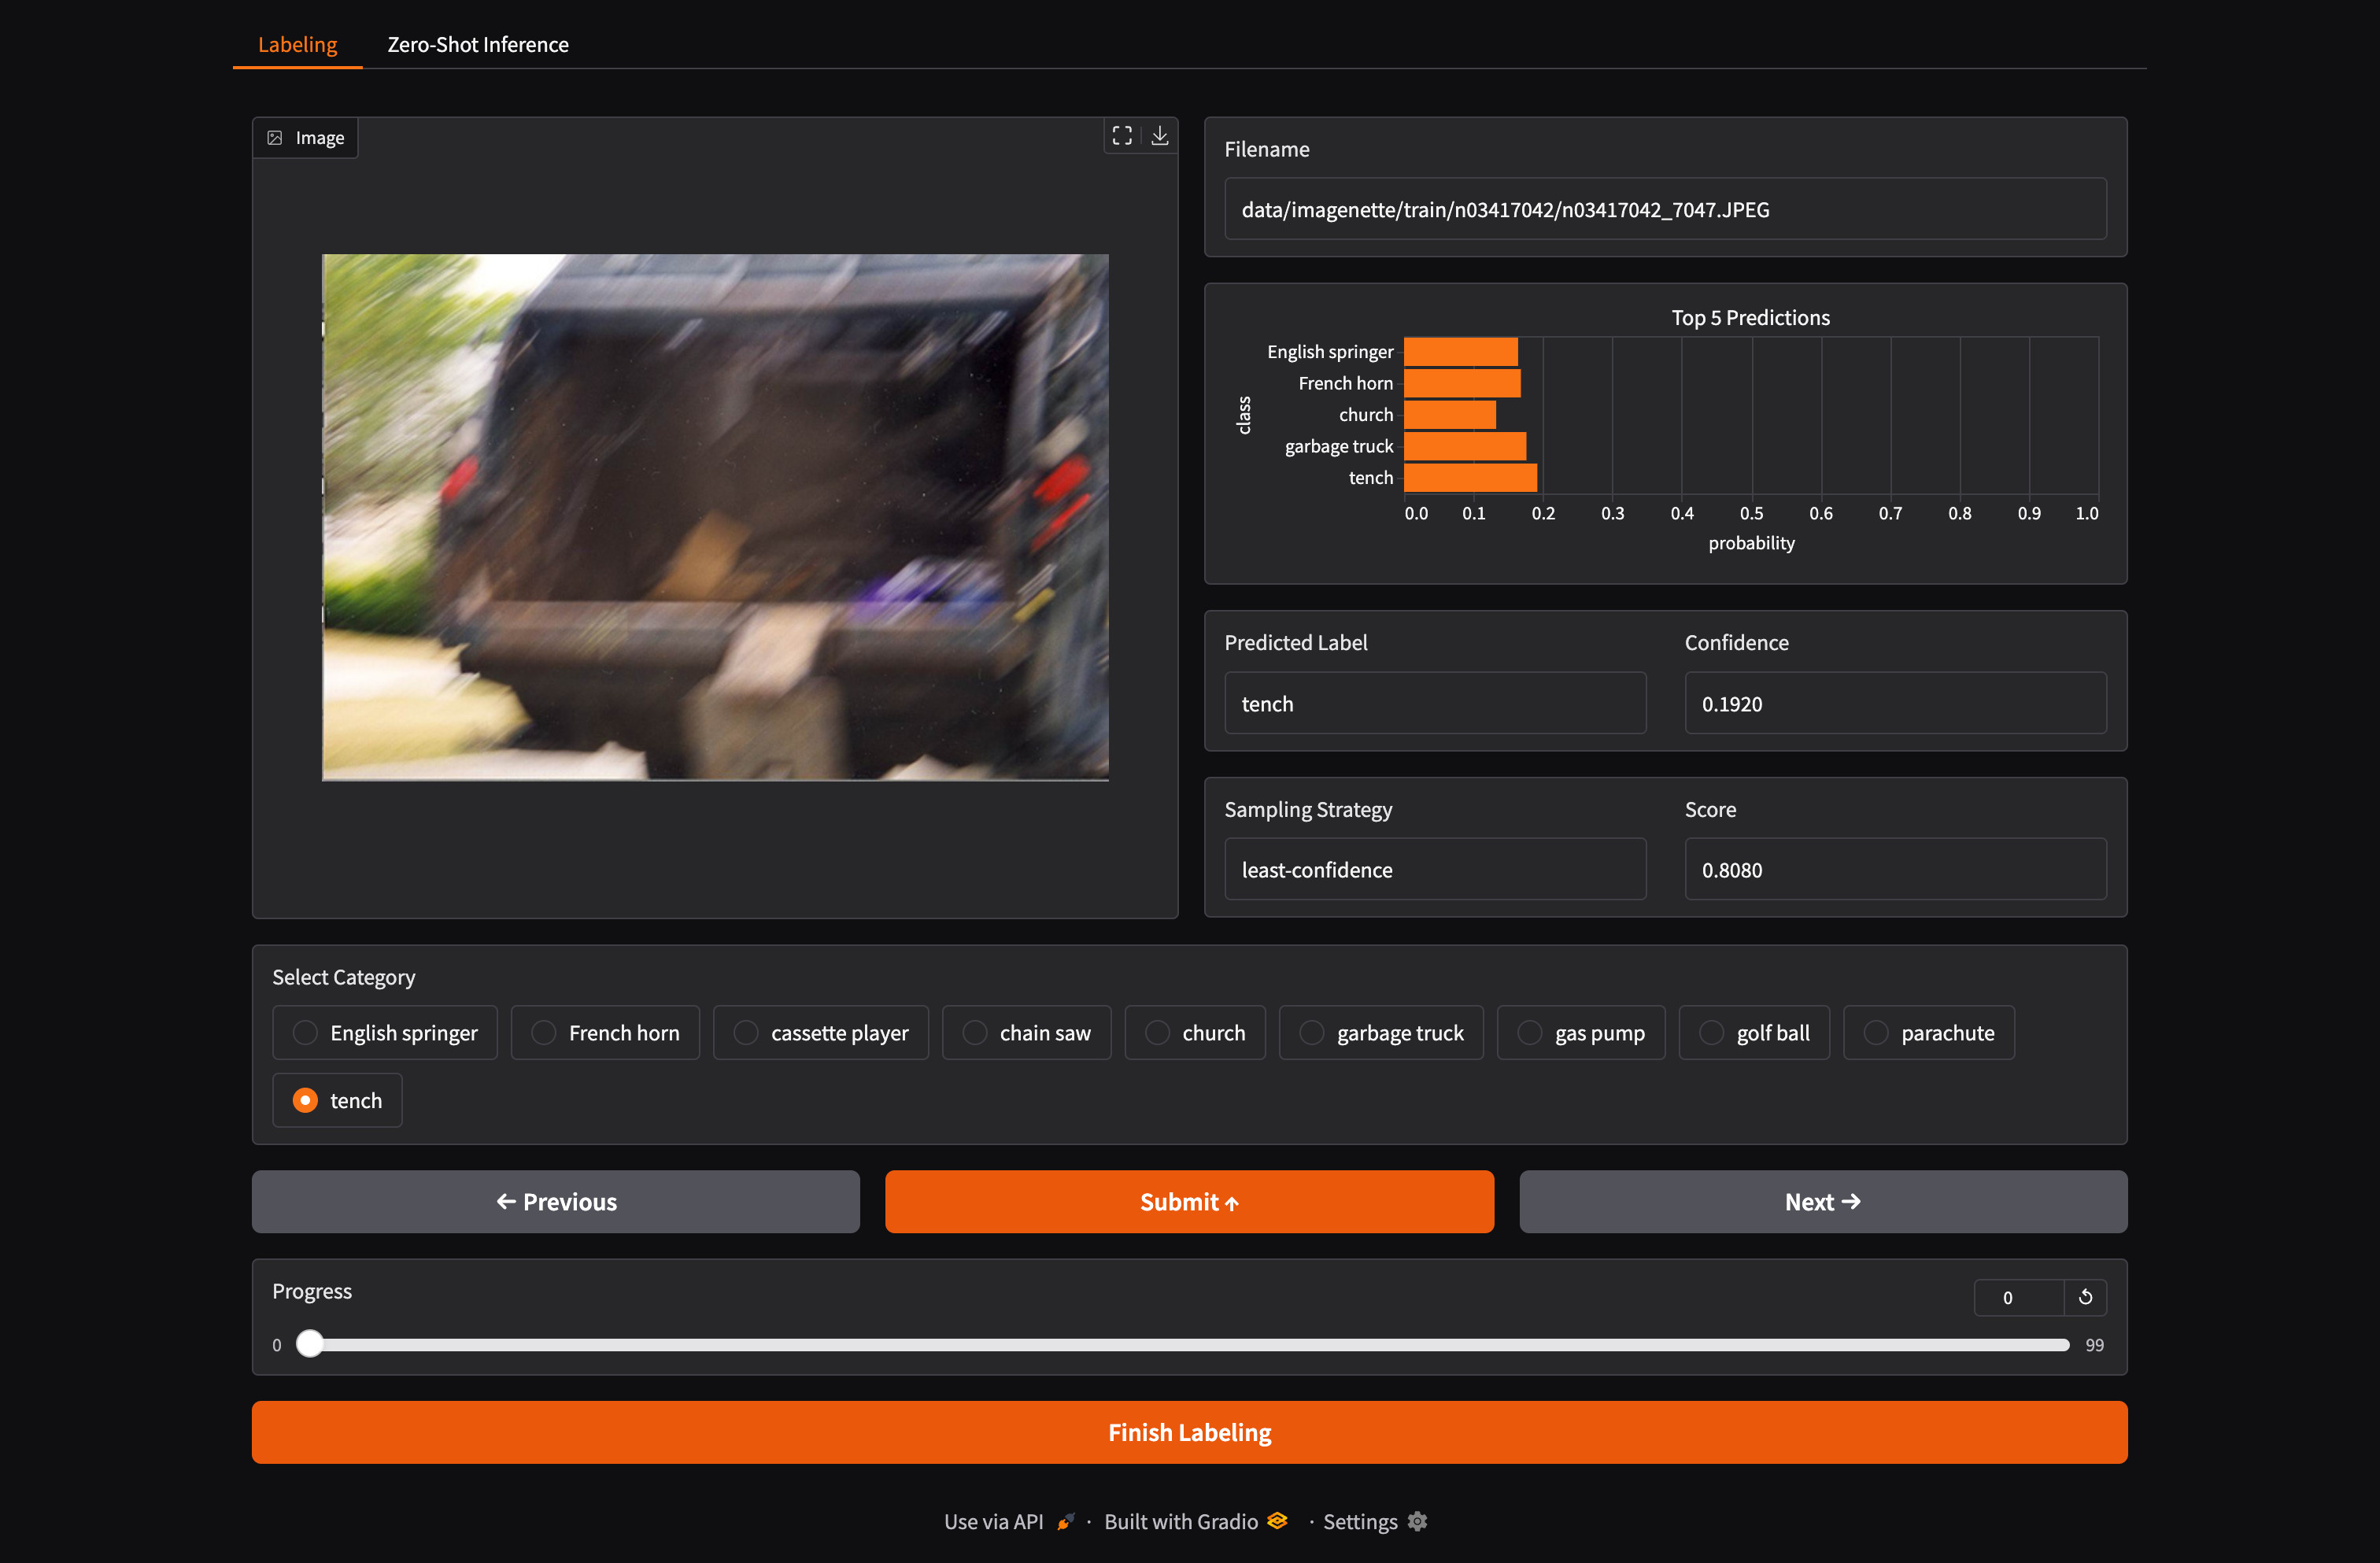

Once you are done labeling, you can inspect the samples you just labeled.

In [16]:
labeled_df = pd.read_parquet("combination.parquet")

labeled_df


filepath             label
0   data/imagenette/train/n03888257/n03888257_3881...         parachute
1   data/imagenette/train/n03417042/n03417042_7047...     garbage truck
2   data/imagenette/train/n03028079/n03028079_5956...            church
3   data/imagenette/train/n03000684/n03000684_1815...         chain saw
4   data/imagenette/train/n01440764/n01440764_1507...             tench
5   data/imagenette/train/n03888257/n03888257_2922...         parachute
6   data/imagenette/train/n03445777/n03445777_4929...         golf ball
7   data/imagenette/train/n02979186/n02979186_2785...   cassette player
8   data/imagenette/train/n03888257/n03888257_4289...         parachute
9   data/imagenette/train/n03888257/n03888257_2103...         parachute
10  data/imagenette/train/n03000684/n03000684_5543...         chain saw
11  data/imagenette/train/n03000684/n03000684_1278...         chain saw
12  data/imagenette/train/n03888257/n03888257_6468...         parachute
13  data/imagenette/train/n03445777/n03445777_1063...         golf ball
14  data/imagenette/train/n03445777/n03445777_1641...         golf ball
15  data/imagenette/train/n03425413/n03425413_2094...          gas pump
16  data/imagenette/train/n02979186/n02979186_2764...   cassette player
17  data/imagenette/train/n03394916/n03394916_3318...       French horn
18  data/imagenette/train/n03888257/n03888257_7115...         parachute
19  data/imagenette/train/n03417042/n03417042_1793...     garbage truck
20  data/imagenette/train/n03028079/n03028079_1363...            church
21  data/imagenette/train/n02979186/n02979186_4087...   cassette player
22  data/imagenette/train/n03417042/n03417042_2143...     garbage truck
23  data/imagenette/train/n03000684/n03000684_8799...         chain saw
24  data/imagenette/train/n03394916/n03394916_3595...       French horn
25  data/imagenette/train/n03417042/n03417042_2594...     garbage truck
26  data/imagenette/train/n03425413/n03425413_1124...          gas pump
27  data/imagenette/train/n03000684/n03000684_1975...         chain saw
28  data/imagenette/train/n02102040/n02102040_5983...  English springer
29  data/imagenette/train/n03000684/n03000684_1609...         chain saw
30  data/imagenette/train/n03445777/n03445777_2967...         parachute
31  data/imagenette/train/n03445777/n03445777_258....         golf ball
32  data/imagenette/train/n02102040/n02102040_1444...  English springer
33  data/imagenette/train/n03888257/n03888257_1929...         parachute
34  data/imagenette/train/n03888257/n03888257_1770...         parachute
35  data/imagenette/train/n03000684/n03000684_9664...         chain saw
36  data/imagenette/train/n03417042/n03417042_2236...     garbage truck
37  data/imagenette/train/n02102040/n02102040_155....  English springer
38  data/imagenette/train/n03445777/n03445777_9976...         golf ball
39  data/imagenette/train/n02979186/n02979186_205....   cassette player
40  data/imagenette/train/n03028079/n03028079_5551...            church
41  data/imagenette/train/n02979186/n02979186_966....   cassette player
42  data/imagenette/train/n01440764/n01440764_2043...             tench
43  data/imagenette/train/n03417042/n03417042_1869...     garbage truck
44  data/imagenette/train/n02102040/n02102040_6763...  English springer
45  data/imagenette/train/n01440764/n01440764_1455...             tench
46  data/imagenette/train/n03028079/n03028079_2489...            church
47  data/imagenette/train/n03425413/n03425413_2110...          gas pump

## Add to dataset

Now that we have labeled the samples, we can add them the existing dataset and save it to a parquet file named `active_labeled.parquet`.

In [ ]:
al.add_to_dataset(labeled_df, output_filename="active_labeled.parquet")

## Repeat

Congratulations! You have completed the first cycle of active learning. We now have a small dataset and a trained model. Now whats left is to repeat the process of predicting, sampling, labeling, and adding to the train set until we have a good model.

## Tracking Progress

You can track the progress of the active learning process by inspecting the .parquet files saved when running the `al.summary()` function.

In this example, I ran 4 cycles of active learning which resulted in the following files:

- `cycle-1_20250201_224658_acc_88.69%_n_100.parquet`
- `cycle-2_20250201_225913_acc_92.18%_n_149.parquet`
- `cycle-3_20250201_232340_acc_93.45%_n_195.parquet`
- `cycle-4_20250201_233055_acc_94.52%_n_243.parquet`

The name of the file contains the cycle name, the date, the accuracy, and the number of labeled samples.


In [17]:
import glob
import pandas as pd

# Get all parquet files with 'cycle' in the name
cycle_files = glob.glob("cycle-*.parquet")

# Read and concatenate all cycle files
all_cycles_df = pd.concat([pd.read_parquet(f) for f in cycle_files], ignore_index=True)

all_cycles_df = all_cycles_df.sort_values(by="name", ascending=True)
all_cycles_df


name  accuracy  train_set_size  valid_set_size  dataset_size  \
1  cycle-1  0.886879              80              20           100   
0  cycle-2  0.921783             120              29           149   
3  cycle-3  0.934522             156              39           195   
2  cycle-4  0.945223             195              48           243   

   num_classes     model  pretrained                              loss_fn  \
1           10  resnet18        True  FlattenedLoss of CrossEntropyLoss()   
0           10  resnet18        True  FlattenedLoss of CrossEntropyLoss()   
3           10  resnet18        True  FlattenedLoss of CrossEntropyLoss()   
2           10  resnet18        True  FlattenedLoss of CrossEntropyLoss()   

  device  seed  batch_size  image_size  
1    mps  None           8         224  
0    mps  None           8         224  
3    mps  None           8         224  
2    mps  None           8         224

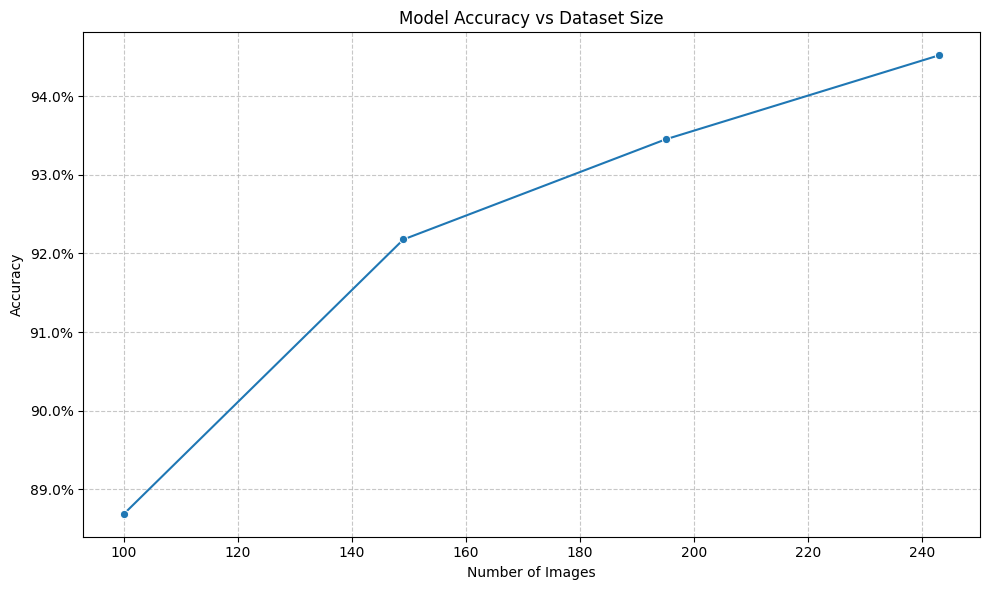

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.lineplot(data=all_cycles_df, x='dataset_size', y='accuracy', marker='o')

plt.title('Model Accuracy vs Dataset Size')
plt.xlabel('Number of Images')
plt.ylabel('Accuracy')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()